In [78]:
import caffe
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import sys 
import os
import time
import matplotlib.cm as cm
import file_io
import shutil

In [79]:
root_path = "/home/hzdz505/dl/datasets/full_data-depth/training"
os.chdir(root_path)

In [82]:
filename2value = lambda x: x[:x.rfind('.')].split('_')[-1]
#img_root_path = "/home/hzdz505/dl/datasets/full_data-depth/training"
img_root_path = "/home/hzdz505/dl/datasets/full_data-depth/additional"

u_direction = False

WEIGHTS_FILE = 'disp_train_iter_60000.caffemodel'
DEPLOY_FILE = 'deploy_full.prototxt'
IMAGE_SIZE = (9, 33) #h,w

#change set_mean below
#MEAN_FILE = root_path + "/" + 'lmdb_data/test_mean.npy'  #not binaryproto, do convert_mean.py first
#MEAN_FILE = 'epi/mean.npy'

MEAN_ROOT = root_path + "/" + "lmdb_data/"
MEAN_FILES = [MEAN_ROOT + '/train_mean.npy',MEAN_ROOT + "/train_mean.npy"]

#len(MEAN_FILES) coincides with IMAGES len(IMAGES)
#IMAGES = ['sideboard','cotton','boxes','dino']
IMAGES =  ["rosemary"] #["medieval2","pens"]

TEST_TXT_PATH = "epi/full_test.txt"
#IMAGE_LIST = 'sideboard/epi/full_test.txt'  #sideboard cotton boxes dino
PRECISION = 0.07
OFFSET = 2
#do not change BATCH_SIZE
BATCH_SIZE = 512  #cpu data fetching operantion is the buttle neck, 1024 didn't work

caffe.set_device(0)
caffe.set_mode_gpu()  
net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)
net.blobs['data'].reshape(BATCH_SIZE, 3, *IMAGE_SIZE)
#print net.blobs['data'].data.shape

#图片预处理设置
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})  #设定图片的shape格式(1,3,9,33)
transformer.set_transpose('data', (2,0,1))    #改变维度的顺序，由原始图片(9,33,3)变为(3,9,33)
#transformer.set_mean('data', np.load(MEAN_FILE))   
# ATTENTION: scale 255 is required，or the network will output same prediction
transformer.set_raw_scale('data', 255)    # 缩放到【0，255】之间
transformer.set_channel_swap('data', (2,1,0))   #交换通道，将图片由RGB变为BGR

print "Performing testing..."

disp_maps = np.zeros((len(IMAGES),BATCH_SIZE,BATCH_SIZE)) #(4,512,512)
for idx in range(len(IMAGES)):
    print "Predicting disp for " + IMAGES[idx] + " ..."
    start = time.time()
    
    image_list = img_root_path + "/" + IMAGES[idx] + "/" + TEST_TXT_PATH
    #change mean
    #transformer.set_mean('data', np.load(img_root_path+ "/"+ IMAGES[idx]+ "/"+ MEAN_FILE))
    transformer.set_mean('data', np.load(MEAN_FILES[idx]))
    
    lb_correct = 0
    va_correct = 0

    with open(image_list, 'r') as f:
        #print type(f)
        lines = f.readlines()
        print "{} images.".format(len(lines))

        i = 0
        while i < len(lines):
            disp_gt = np.zeros(BATCH_SIZE)
            lb_gt = np.zeros(BATCH_SIZE)
            for j in range(BATCH_SIZE):
                filename = img_root_path + "/" + lines[i+j][:-1]  #[:-1]remove /n
                image = caffe.io.load_image(filename) #, False gray or rgb
                #print image.shape
                transformed_image = transformer.preprocess('data', image)
                net.blobs['data'].data[j] = transformed_image
                #calculate gt
                disp_gt[j] = float(filename2value(filename))
                lb_gt[j] = int((disp_gt[j] + OFFSET)/PRECISION + 0.5) #disp四舍五入

            #forward BATCH_SIZE images
            output = net.forward()

            #blobs['fc5'].data:(512,59) 所以argmax(1)指示沿axis 1求最大值
            lb_pre = net.blobs['fc5'].data.argmax(1)  #（BATCH_SIZE）
            disp_pre = lb_pre * PRECISION - OFFSET    #（BATCH_SIZE）

            lb_correct += sum(lb_pre == lb_gt)
            va_correct += sum(abs(disp_pre  - disp_gt) <= PRECISION )

            #save prediction as BATCH_SIZE
            if u_direction == True:
                disp_maps[idx,i/BATCH_SIZE,:] = disp_pre
            else:
                disp_maps[idx,:,i/BATCH_SIZE] = disp_pre

            i += BATCH_SIZE
            #print "%d images forward done..."%i

    end = time.time()
    print  "Label accuracy: {:.4f}".format(float(lb_correct) / len(lines))
    print  "Value({}) accuracy: {:.4f}".format(PRECISION,float(va_correct) / len(lines)) 
    print "{:.2f} s".format(end - start)
    print ""

print "All done."

Performing testing...
Predicting disp for rosemary ...
262144 images.
Label accuracy: 0.1169
Value(0.07) accuracy: 0.2238
55.30 s

All done.


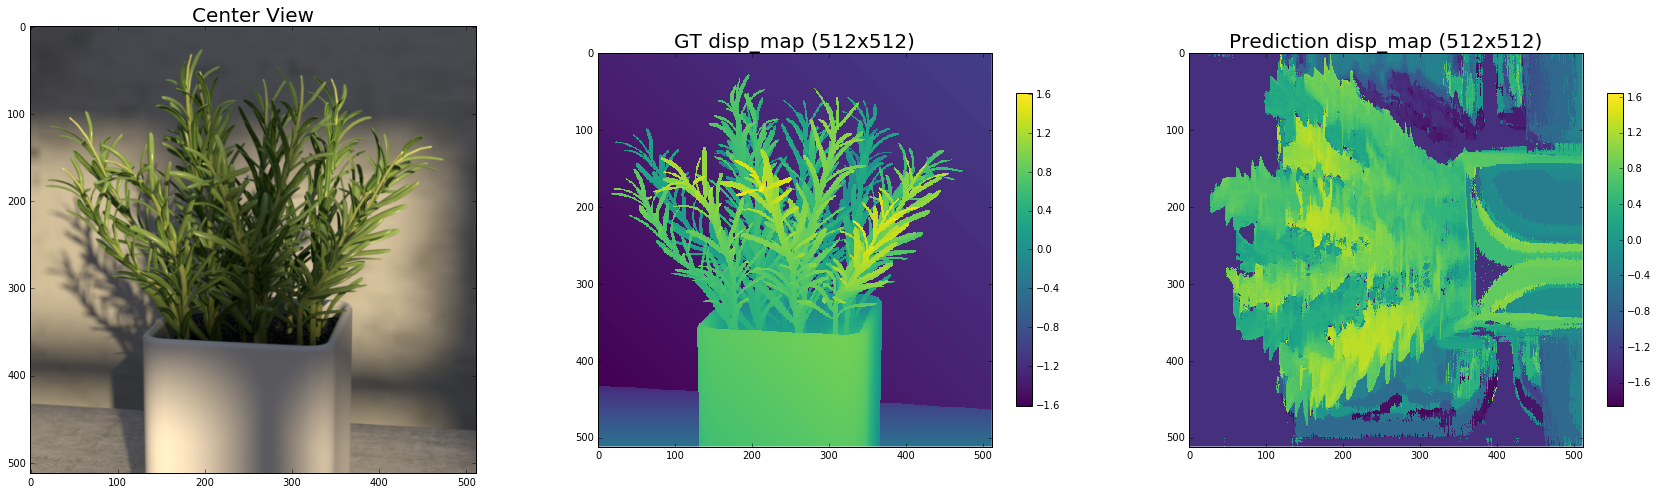

In [83]:
#display disp_map
save_folder = img_root_path + "/predictions" 
if not os.path.exists(save_folder):
    #shutil.rmtree(save_folder)
    os.mkdir(save_folder)

save_folder += "/train_mean"
#save_folder += "/test_mean"
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
os.mkdir(save_folder)
    
#plt.axes.titlesize  = 30 # fontsize of the axes title
#plt.axes.labelsize  = 30 # fontsize of the x any y labels
    
for idx in range(len(IMAGES)):
    data_folder = img_root_path + "/" + IMAGES[idx]
    light_field = file_io.read_lightfield(data_folder)
    #disp_map_highres = file_io.read_disparity(data_folder, highres=True)
    disp_map_lowres = file_io.read_disparity(data_folder, highres=False)
    #depth_map_lowres = file_io.read_depth(data_folder, highres=False)
    #print type(depth_map_lowres),depth_map_lowres.shape

    rows, cols = 1, 3
    fig = plt.figure(figsize=(30, 8),facecolor=(1, 1, 1))
    # 设置刻度字体大小
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)

    plt.subplot(rows, cols, 1)
    plt.title("Center View", fontsize=20)
    plt.imshow(light_field[4,4,:,:,:])

    plt.subplot(rows, cols, 2)
    plt.title("GT disp_map (%dx%d)" % np.shape(disp_map_lowres), fontsize=20)
    cc = plt.imshow(disp_map_lowres, cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)

    plt.subplot(rows, cols, 3)
    plt.title("Prediction disp_map (%dx%d)" % np.shape(disp_maps[idx]), fontsize=20)
    cc = plt.imshow(disp_maps[idx], cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)

    '''
    plt.subplot(rows, cols, 4)
    plt.title("Depth Map (%dx%d)" % np.shape(depth_map_lowres), fontsize=20)
    cc = plt.imshow(depth_map_lowres, cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)
    '''
    file_name = save_folder + "/" + IMAGES[idx] + "_disp.png"
    plt.savefig(file_name)
plt.show()

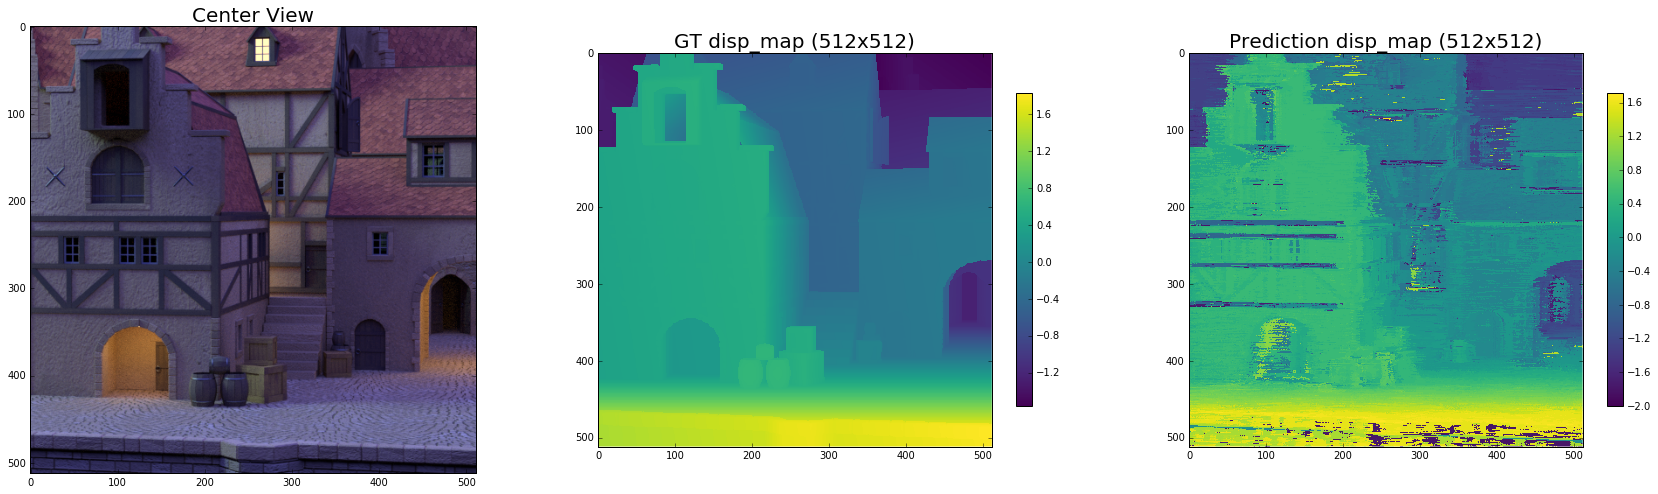

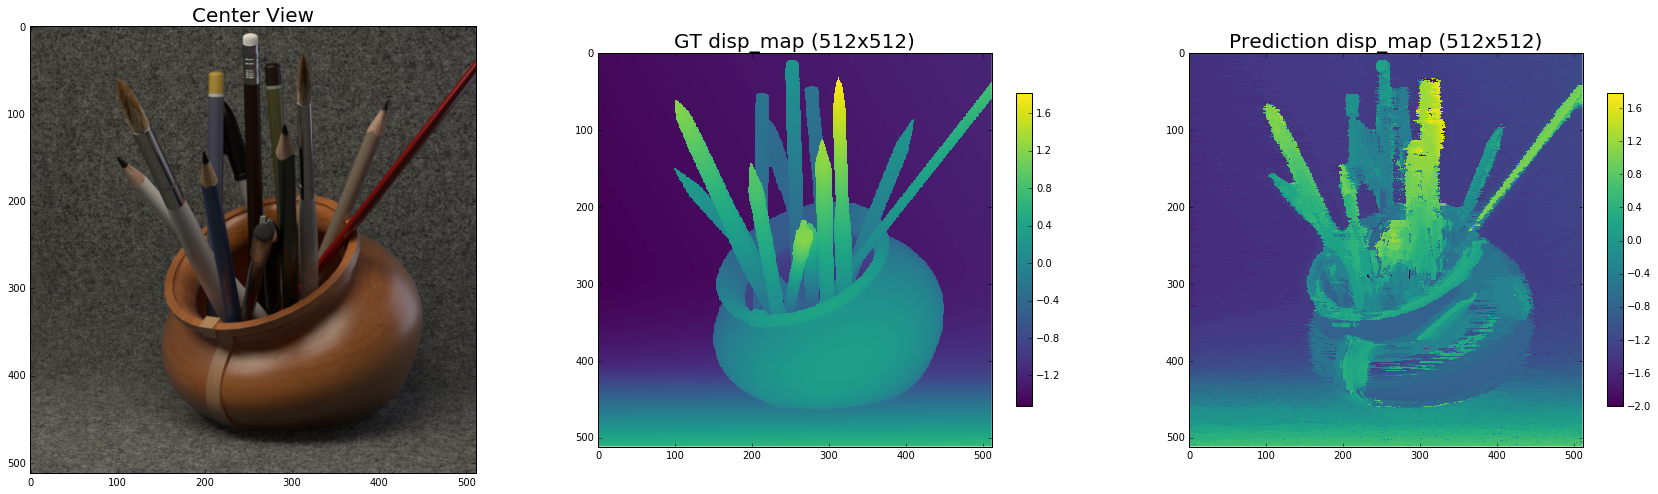

In [77]:
#display disp_map
save_folder = img_root_path + "/predictions" 
if not os.path.exists(save_folder):
    #shutil.rmtree(save_folder)
    os.mkdir(save_folder)

save_folder += "/train_mean"
#save_folder += "/test_mean"
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
os.mkdir(save_folder)
    
#plt.axes.titlesize  = 30 # fontsize of the axes title
#plt.axes.labelsize  = 30 # fontsize of the x any y labels
    
for idx in range(len(IMAGES)):
    data_folder = img_root_path + "/" + IMAGES[idx]
    light_field = file_io.read_lightfield(data_folder)
    #disp_map_highres = file_io.read_disparity(data_folder, highres=True)
    disp_map_lowres = file_io.read_disparity(data_folder, highres=False)
    #depth_map_lowres = file_io.read_depth(data_folder, highres=False)
    #print type(depth_map_lowres),depth_map_lowres.shape

    rows, cols = 1, 3
    fig = plt.figure(figsize=(30, 8),facecolor=(1, 1, 1))
    # 设置刻度字体大小
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)

    plt.subplot(rows, cols, 1)
    plt.title("Center View", fontsize=20)
    plt.imshow(light_field[4,4,:,:,:])

    plt.subplot(rows, cols, 2)
    plt.title("GT disp_map (%dx%d)" % np.shape(disp_map_lowres), fontsize=20)
    cc = plt.imshow(disp_map_lowres, cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)

    plt.subplot(rows, cols, 3)
    plt.title("Prediction disp_map (%dx%d)" % np.shape(disp_maps[idx]), fontsize=20)
    cc = plt.imshow(disp_maps[idx], cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)

    '''
    plt.subplot(rows, cols, 4)
    plt.title("Depth Map (%dx%d)" % np.shape(depth_map_lowres), fontsize=20)
    cc = plt.imshow(depth_map_lowres, cmap=cm.viridis, interpolation="none")
    plt.colorbar(cc, shrink=cb_shrink)
    '''
    file_name = save_folder + "/" + IMAGES[idx] + "_disp.png"
    plt.savefig(file_name)
plt.show()


In [ ]:
'''
plt.figure(figsize=(20, 4))
cb_shrink = 0.7
plt.title("Disparity Map (%dx%d)" % np.shape(disp_map))
cc = plt.imshow(disp_map, cmap=cm.viridis, interpolation="none")
plt.colorbar(cc, shrink=cb_shrink)
plt.show()
'''

In [ ]:
#sideboard
Label accuracy: 0.653228759766
Value(0.07) accuracy: 0.833206176758
66.3795058727 s
##use same npy
Label accuracy: 0.966812133789
Value(0.07) accuracy: 0.994766235352
53.261909008 s

#boxes
Label accuracy: 0.289848327637
Value(0.07) accuracy: 0.392894744873
62.8954157829 s

Label accuracy: 0.91845703125
Value(0.07) accuracy: 0.977188110352
53.8398320675 s

#dino
Label accuracy: 0.45325088501
Value(0.07) accuracy: 0.65051651001
63.0426528454 s

Label accuracy: 0.950420379639
Value(0.07) accuracy: 0.995292663574
55.0474040508 s

#cotton
Label accuracy: 0.367164611816
Value(0.07) accuracy: 0.562713623047
62.6860480309 s

Label accuracy: 0.976650238037
Value(0.07) accuracy: 0.998882293701
52.6186749935 s

In [ ]:
'''
#!/usr/bin/env python
import numpy as np
import sys,caffe

def binary2npy(lmdb_paths):
    mean_bin_path = "/mean.binaryproto"
    mean_npy_path = "/mean.npy"
    
    blob = caffe.proto.caffe_pb2.BlobProto()
    for lmdb in lmdb_paths:
        bin_mean = open( lmdb+mean_bin_path , 'rb' ).read()
        blob.ParseFromString(bin_mean)
        arr = np.array( caffe.io.blobproto_to_array(blob) )
        npy_mean = arr[0]
        np.save( lmdb+mean_npy_path , npy_mean )
    
#bin 2 npy
#root_path = "/home/hzdz505/dl/datasets/full_data-depth/training"
lmdb_paths = [root_path+"/sideboard/epi",root_path+"/cotton/epi",root_path+"/boxes/epi",root_path+"/dino/epi"]
    
binary2npy(lmdb_paths)
print "Done"
'''